**Done By : ABDALLAH Zakaria**

This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [194]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [233]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')
# print to check if the dimension of the image is managebale where the size of the block is 16x16 it is dividable by 16
print(im1.shape)


(288, 352)


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1a6845010a0>)

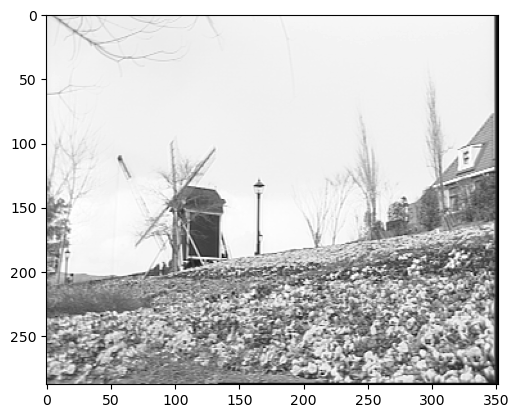

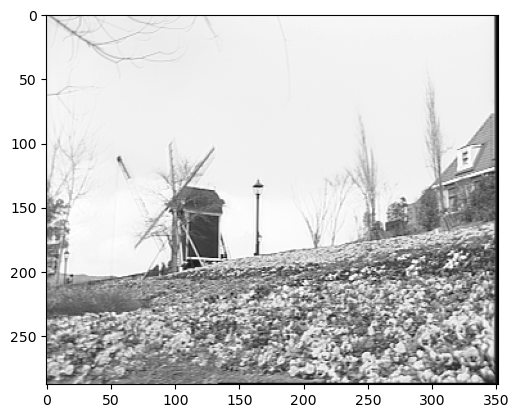

In [234]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [197]:
# here we take the size blcok is equal to 16x16 within a radius equal to 8
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8  # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [198]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    cur_col = np.shape(cur)[1]
    cur_row = np.shape(cur)[0]
    # Non-regularized search
    if lamb == 0.:
        for c in range(0,cur_col,bcol) : # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow) :
                # current block selection
                B = cur[r : r + brow,c : c + bcol] # Block

                # Initialization:
                
                costMin = np.inf
                # the best one is that the block still not moving
                Rbest = [0,0]
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        block_error = np.linalg.norm(B-block_extracted)**2
                        if block_error<costMin: # Save the results if they are better than the previous ones
                            costMin = block_error
                            Rbest = [drow,dcol]
                # so we search (y,x,2) so if we call the (y,x,:) these are the row and column displacment for instance (3,2,:) = [-2,7] so we need to move the
                # pixel (3,2) 2 pixel down and 7 pixel right since it corresponds to y and x organization.
                mvf[r:r+brow, c:c+bcol, 0] = Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = Rbest[1] # Once the loop is over, save the best column displacement field
                # the need behind adding search parameter is that we use the expanded image which is already expanded by the size of the extention which is 16 
                prediction[r:r+brow,c:c+bcol]= ref_extended[search+Rbest[0]+r:search+Rbest[0]+r+brow, search+Rbest[1]+c:search+Rbest[1]+c+bcol]
                
    else: # Regularized search
        for c in range(0,cur_col,bcol): # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                # here the intial value or displacement that we can put is [0,0] assuming that the blcok did not move away
                Rbest = [0,0]
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        # as mentioned in the course the reglarized term is calculated as a diffrence between the current candidate block and the median of the neighboring pixels
                        pos_cur = [drow,dcol]
                        regularized_term_to_be_calculated = lamb*(np.linalg.norm(pV-pos_cur))
                        cost = np.linalg.norm(B-block_extracted)**2 + regularized_term_to_be_calculated # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin=cost
                            # save the row and column displacement for each pixel 
                            Rbest=[drow,dcol]
                
                
                
                mvf[r:r+brow,c:c+bcol,0]=Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=ref_extended[search+r+drow:r+drow+search+brow,search+c+dcol:search+c+dcol+bcol]
                
                
    mvf = -mvf # For compatibility with standards
    return mvf, prediction

In [206]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius,lamb=3)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

In [207]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

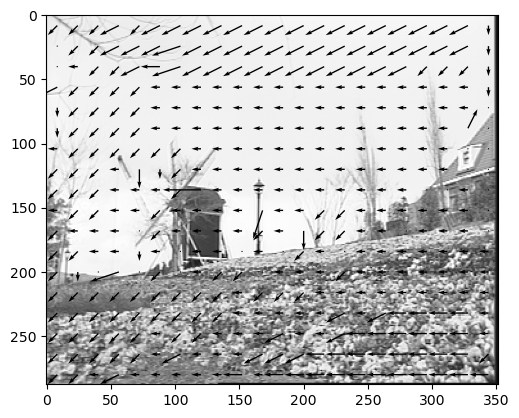

In [208]:
displayMVF(im1,mvf_ssd,brow)


Answers:

Remarks based on the observation :

the stable regions are in the down and the changes that take place hold in the top medium of the image.

it is clear that using the ssd we can not get rid of outliers as seen in the vetor image so to avoid that we can use the regularized sad using the l1 norm.

In addition, some blocks, specificaly those in the sky, seem to move from where they started, which isn't right. This mistake happens because we only look at how different the 

colors are between two blocks and don't consider how far apart they are. So, even if two blocks are in a similar part of the image, they might seem very different because 

they're close together.

changes if we change the parametes :

*when you change the search_radius we got vectors that are long meaning that the corresponding block is so far from the one that we seach to find.

*when we increase the number of block size we got less vectors but the outliers still exist even if we decrease the radius size.

in general, making the blocks bigger reduces the chance of finding a block far away that looks very different from its neighbors, so there are fewer errors in the motion vectors. However, if we increase the area that we're looking at, we're more likely to find blocks that look similar to their neighbors, even if they're far away, which can increase the number of errors in the motion vectors.

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

In this image, we shift blocks based on previously obtained motion vectors. The outcome is satisfactory if the resulting image closely resembles im2. When applying motion compensation to im1, we should obtain an image that is close to the im2 (this will be ideally if and only if the vectors are well determined).

In [209]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1a685c2e820>)

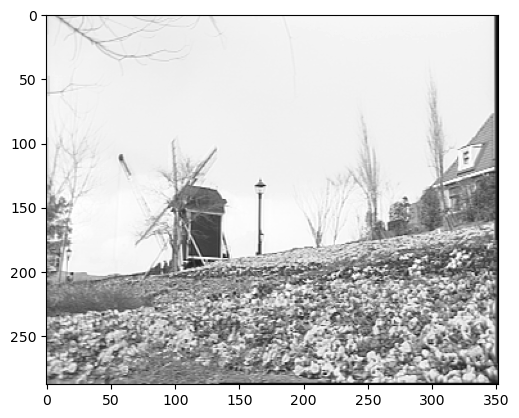

In [210]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

PSNR, or Peak Signal-to-Noise Ratio, is a common measure used to quantify the quality of a reconstructed image compared to its original image. It is defined as follows:

$$\text{PSNR} = 10 \cdot \log_{10} \left(\frac{MAX_I^2}{MSE}\right)$$

where:

- $MAX_I$ is the maximum possible pixel value of the image. For instance, in an 8-bit grayscale image, where pixel values range from 0 to 255, $MAX_I = 255$.

- $MSE$ stands for Mean Squared Error between the original and the reconstructed image, and it's calculated as:

$$MSE = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left[ I(i, j) - K(i, j) \right]^2$$




In [211]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    
    c1,r1 = im1.shape[1],im1.shape[0]
    c2,r2 = im2.shape[1],im2.shape[0]
    # check if they have the same shape
    if c1 != c2 or r2!= r1:
        im2 = cv2.resize(im1,(c1,r1))

    
    MSE_ERROR = (1/(c1*r1))*np.sum((im2-im1)**2)  
    print(f'the mean square error is :{MSE_ERROR}') 

    psnr = 10*np.log10(255**2/MSE_ERROR)

    return psnr

In [212]:
psnr_ssd = PSNR(im2,mc_ssd)
print(f'the resulting PSNR is :{psnr_ssd}')

the mean square error is :1465.4553444602275
the resulting PSNR is :16.471077717679627


it is clear that with image compensated we got a slightly greater value than the one obtained from the comparing the im1 and im2

so when we change the size of block or even the raduis we do not get a value greather than the one obtained using the compensated method

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [213]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    cur_col = np.shape(cur)[1]
    cur_row = np.shape(cur)[0]
    # Non-regularized search
    if lamb == 0.:
        for c in range(0,cur_col,bcol) : # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow) :
                # current block selection
                B = cur[r : r + brow,c : c + bcol] # Block

                # Initialization:
                
                costMin = np.inf
                # the best one is that the block still not moving
                Rbest = [0,0]
                
                # Loop on candidate displacement vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        block_error = np.sum(np.abs(B-block_extracted))
                        
                        if block_error<costMin: # Save the results if they are better than the previous ones
                            costMin = block_error
                            Rbest = [drow,dcol]
                # so we search (y,x,2) so if we call the (y,x,:) these are the row and column displacment for instance (3,2,:) = (-2,7) so we need to move the
                # pixel (3,2) 2 pixel down and 7 pixel right since it corresponds to y and x organization.
                mvf[r:r+brow, c:c+bcol, 0] = Rbest[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow, c:c+bcol, 1] = Rbest[1] # Once the loop is over, save the best column displacement field
                # the need behind adding search parameter is that we use the expanded image which is already expanded by the size of the extention which is 16 
                prediction[r:r+brow,c:c+bcol]= ref_extended[search+Rbest[0]+r:search+Rbest[0]+r+brow, search+Rbest[1]+c:search+Rbest[1]+c+bcol]
        

                
    else: # Regularized search
         for c in range(0,cur_col,bcol): # for each block in the current image, find the best corresponding block in the reference image
            for r in range(0,cur_row,brow):
                # current block selection
                B = cur[r:r+brow,c:c+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                # here the intial value or displacement that we can put is [0,0] assuming that the blcok did not move away
                Rbest = [0,0]
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search,search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search,search):# rcol = candidate displacement vector over the rows
                        
                        block_extracted = ref_extended[search+r+drow:search+r+drow+brow,search+c+dcol:search+c+dcol+bcol]
                        # as mentioned in the course the reglarized term is calculated as a diffrence between the current candidate block and the median of the neighboring pixels
                        

                        pos_cur = [drow,dcol]

                        # here it is obtained just by computing the norm of the difference of the candidate displacment and the median of the neighboring displacement.
                        regularized_term_to_be_calculated = lamb*(np.linalg.norm(pV-pos_cur))

                        cost = np.sum(np.abs(B-block_extracted)) + regularized_term_to_be_calculated # here, encore the REGULARIZED cost function
                        if cost<costMin: # Save the results if they are better than the previous ones
                            costMin=cost
                            # save the row and column displacement for each pixel 
                            Rbest=[drow,dcol]
                
                
                
                mvf[r:r+brow,c:c+bcol,0]=Rbest[0]  # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= Rbest[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=ref_extended[search+r+drow:r+drow+search+brow,search+c+dcol:search+c+dcol+bcol]
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [215]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius,lamb=3)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

yes we can see a slightly diffence where some of the outliers vectors are removed (the number of ouliers vectors are removed)

and the result is more smooth which means that the method using the sad is more performant that the one that uses ssd (i would mention that i figured the difference by conting the outliers and i ensured that sad reduced them)

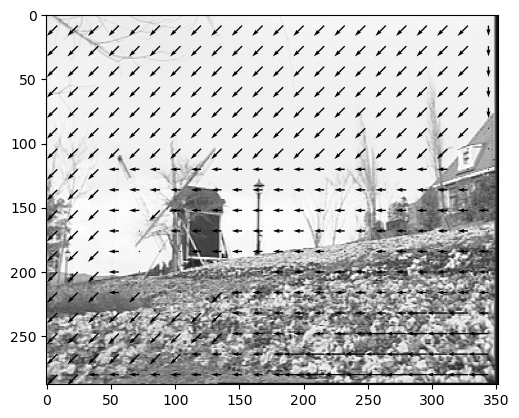

In [216]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

Asnwer: The SSD dissimilarity gives a smoother result than the sad 

but we can see that the SAD allows us to get rid a little bit of outliers but if we need to eliminate all the outliers it is recommended to add a regularization term

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1a6860104c0>)

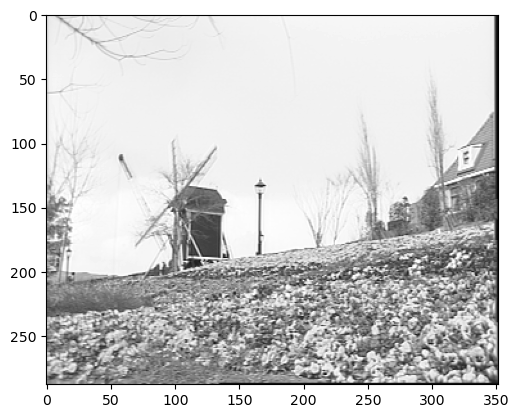

In [217]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [219]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

the mean square error is :1420.0873875473485
16.60765290596222


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Answer :

It tries to make the sum of squared differences (SSD) between two blocks as small as possible, but with an added term that considers the distance between the blocks. This helps keep the motion between the blocks as small as possible.

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

Answer :so the unregularized one give a result slightely lower than the one that we got using the regularized one,

for instance i tried lambda from 0.001 to 10 and i have noticed that the PNSR ranges from  16.46 to 16.47.

it could be 0.01 the best one for me because it satistfy strongly the constraint.


### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

Answer :

so the unregularized one give a result slightely lower than the one that we got using the regularized one,

for instance i tried lambda from 0.001 to 10 and i have noticed that the PNSR ranges from 16.40 to 17.65.

it could be 0.01 the best one for me because it satistfy strongly the constraint.


now comparing the result of the sad to ssd we have noticed that we can acheive a better PNSR using the regularized sad because it can get rid of outliers and noise.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [220]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x1a685b030d0>)

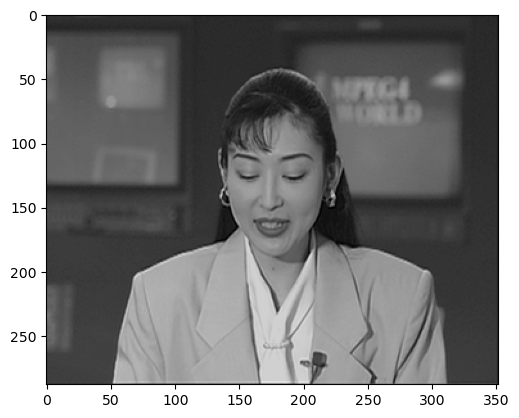

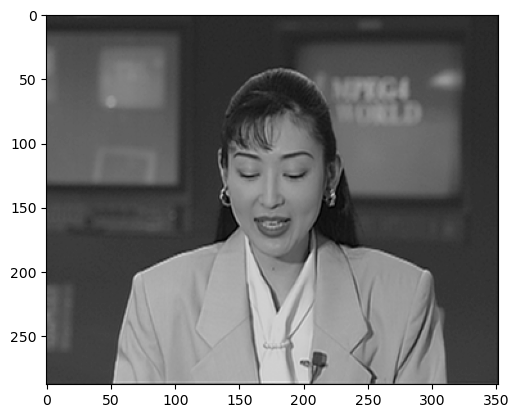

In [221]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

The equation (optic flow equation) that we need to solve is the following : $f_t + u*f_x +v*f_t = 0$

where $f_x$ is the dervative of f with respect to x 

same for $f_y$

In [235]:
brow = 16; bcol=16; search_radius =13;

In [236]:
a=np.array([-1., 8., 0., -8., 1.])
kernel1D = np.expand_dims(((1./12.)*a),axis=1).T
fx = convolve2d(im1,kernel1D,'same')
fy = convolve2d(im1,kernel1D,"same")

In [237]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg=convolve2d(u,kernel_1,'same')
        vAvg=convolve2d(v,kernel_1,'same')
        # now we need to compute the laplacian of f
        kernel_lap = np.array([[0,1,0],[1,-4,1],[0,1,0]])
        lap_f = convolve2d(im1,kernel_lap,'same')
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = u - fx*((uAvg*fx+vAvg*fy+ft)/(alpha**2 + np.linalg.norm(lap_f)**2))
        v = v - fy*((uAvg*fx+vAvg*fy+ft)/(alpha**2 + np.linalg.norm(lap_f)**2))
        
    # since there is a risk to obtain a NAN not a number in the matrix so to avoid that we can do the following codes   
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [238]:
alpha = 25
ite = 1000

uInitial = np.zeros((im1.shape[0],im1.shape[1])) # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = np.zeros((im1.shape[0],im1.shape[1]))
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

Answer: 

yes we can see an impovements especially in the small movement where the area are homogenuous, despite of that we can see that still outliers exist.

but it efficiently can detect the small or local movemment.


Plus, i have tested the flowers image and it gives me a PNSR equal to 18.84 while using the regularized ssd we got 16.47 and we know that as long as the value of PNSR is high so our method is more performent and more efficient.

for the case of the sad with regularized we get 16.55 which is better than the ssd regularized but the one using optic flow still better with 18.84

and using the oprtic flow we solved the problem mentioned in the first part where we detect wrongly a movement in the sky.




the mean square error is :848.2402953050984


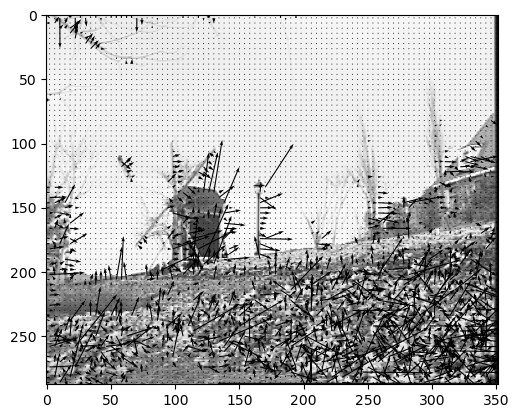

In [239]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [240]:
psnr_hs

18.84561461274073